In [39]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
data = pd.read_csv('Data/smeardata_20090101120000.csv', parse_dates=[[0,1,2,3,4,5]]) 

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5784480 entries, 0 to 5784479
Data columns (total 2 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Year_Month_Day_Hour_Minute_Second  object 
 1   HYY_META.WSU168                    float64
dtypes: float64(1), object(1)
memory usage: 88.3+ MB


In [73]:
data.isnull().sum()


Year_Month_Day_Hour_Minute_Second         0
HYY_META.WSU168                      169047
dtype: int64

In [74]:
data['Time']=pd.to_datetime(data['Year_Month_Day_Hour_Minute_Second'],format='%Y %m %d %H %M %S')
del data['Year_Month_Day_Hour_Minute_Second']
data.rename(columns={'HYY_META.WSU168':'Horizontal wind speed at 16.8 m height'},inplace=True)
data=data.set_index('Time',drop=True)

In [75]:
data=data.fillna(data.mean())
#data.head()

In [76]:
data.index.is_unique
data.isnull().sum()

Horizontal wind speed at 16.8 m height    0
dtype: int64

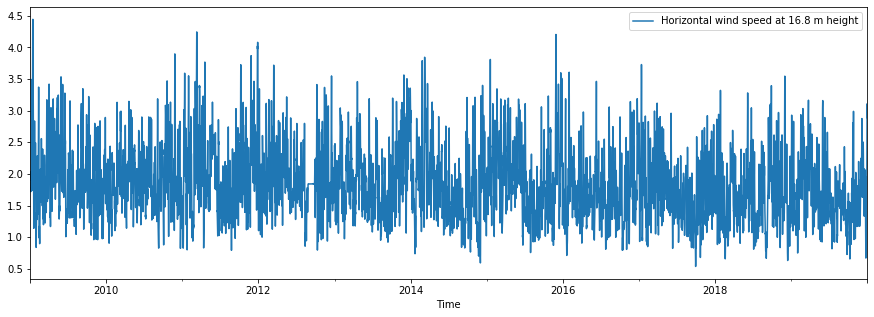

In [77]:
data.resample('H').mean().rolling(window=30).mean().rolling(window=30).mean().plot(figsize=(15,5))

In [80]:
data.resample('H').mean().describe()

,Horizontal wind speed at 16.8 m height
count,96408.000000
mean,1.841594
std,0.810822
min,0.181333
25%,1.246167
50%,1.736667
75%,2.301000
max,6.639500


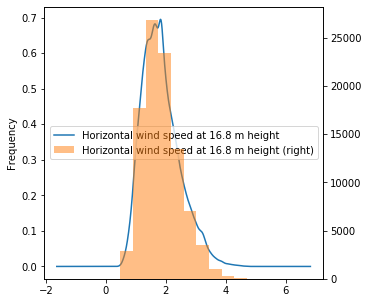

In [79]:
# show the distribution of wind speed, it looks like a gamma distribution.
ax=data.resample('H').mean().rolling(window=24).mean().plot(kind='kde',figsize=(5,5))
data.resample('H').mean().rolling(window=24).mean().plot(kind='hist',ax=ax,secondary_y=True,alpha=0.5);

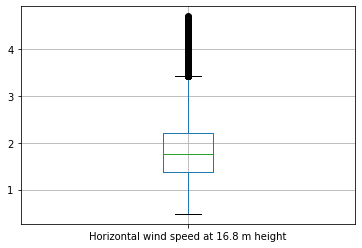

In [81]:
# boxplot outliers represent high-speed wind, 
# also suggests the distribution is not normal distribution but gamma distribution.
data.resample('H').mean().rolling(window=24).mean().boxplot()

In [83]:
data.resample('H').mean().quantile(0.95)

Horizontal wind speed at 16.8 m height    3.3725
Name: 0.95, dtype: float64

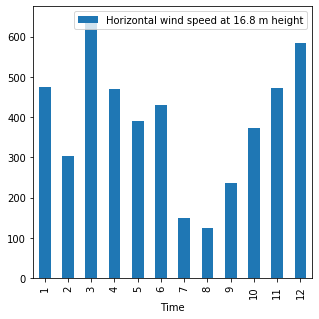

In [84]:
# wind with speed higher than 3.398258 m/s(≈0.95% percentile of entire dataset ,means high wind) 
# rarely happend in August.the average wind speed of August is also low. 
slice_=data.resample('H').mean()[data.resample('H').mean()['Horizontal wind speed at 16.8 m height']>3.398258]
slice_.groupby(slice_.index.month).count().plot(kind='bar',figsize=(5,5))

### decompose data to detect potential trends and seasonalities
- Fistly, in a short time interval to find local pattern and local trend: wind speed daily changes. The result shows daily periodic variation of wind speed, and this can also be seen in aggregation analysis (**groupby()+median()**), wind speed peaks at 12:00-13:00, and this pattern repeat at regular interval: **one Day**


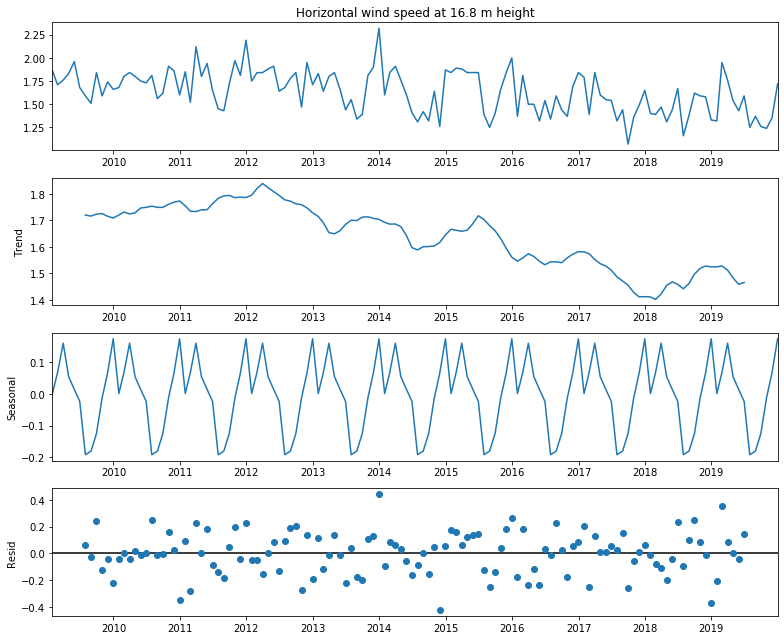

In [85]:
# decomposition
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 11,9
decomposition=sm.tsa.seasonal_decompose(data.resample('M').median()['Horizontal wind speed at 16.8 m height'])
fig1=decomposition.plot()
plt.show()

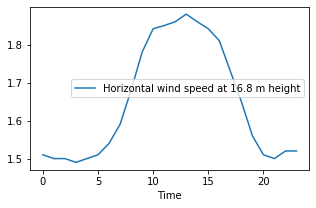

In [86]:
#speed change over hours
data.groupby(by=data.index.hour).median().plot(figsize=(5,3))

- Secondly, in big picture to explore how wind speed change yearly, we can see wind speed periodically change every year. Around August wind speed is lowest, around Martch it gets the highest point.

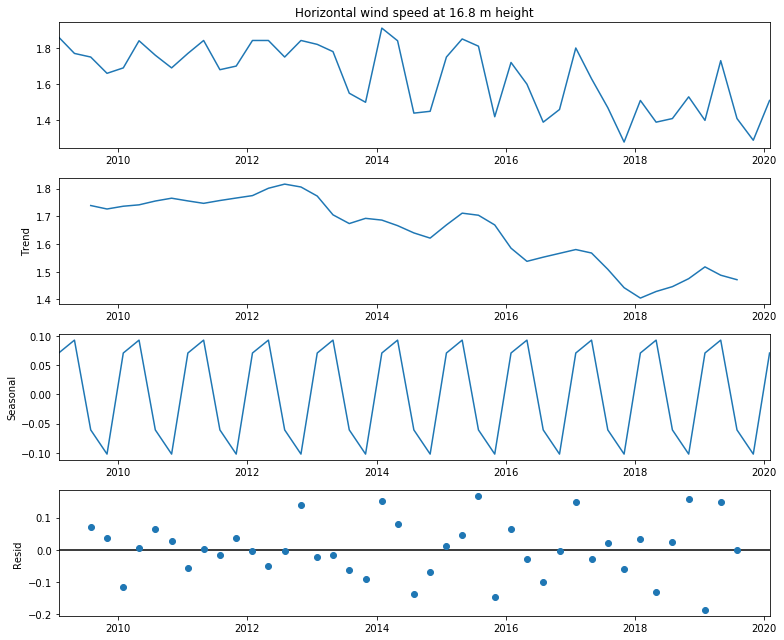

In [87]:
rcParams['figure.figsize'] = 11,9
decomposition=sm.tsa.seasonal_decompose(data.resample('3M').median()['Horizontal wind speed at 16.8 m height'])
fig2=decomposition.plot()

### Detect autocorrelation 

- Autocorrelation coefficients confirmed that wind speed's season change is regular 

- Autocorrelation is **statistically  significant**, if the autocorrelation coefficient is **outside** the confidence interval. annotated by the red arrow. This confirmed the conclusion  of **decomposition**: wind speed periodically changes every year month by month.The length of the period is **12**. we can confirm this again by **stationary test** soon afterwards.


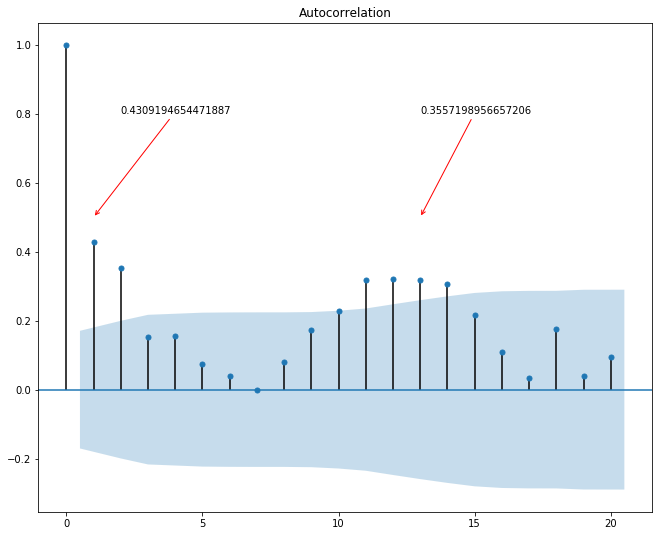

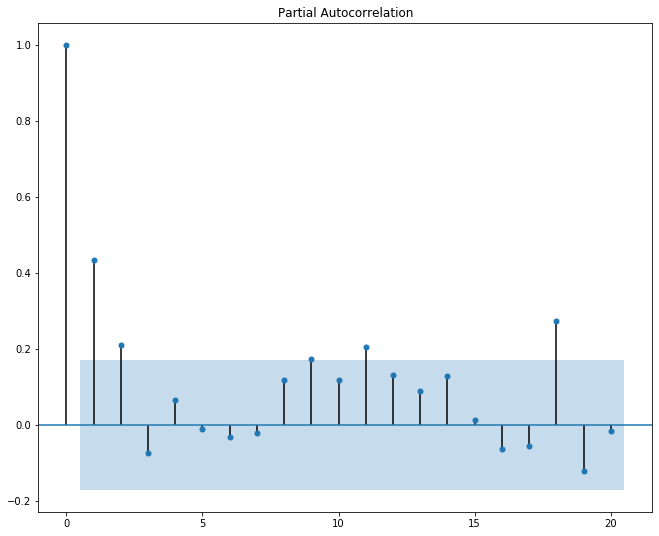

In [88]:
from statsmodels.graphics import tsaplots
ax1=tsaplots.plot_acf(data.resample('M').median()['Horizontal wind speed at 16.8 m height'],lags=20)
anno=data.resample('M').median()['Horizontal wind speed at 16.8 m height'].autocorr(lag=1)
anno_=data.resample('M').median()['Horizontal wind speed at 16.8 m height'].autocorr(lag=12)
plt.annotate(f'{anno}', xy=(1,0.5),xytext=(2,0.8),
             arrowprops=dict(color='red', arrowstyle="->",
                            connectionstyle="arc3"))
plt.annotate(f'{anno_}', xy=(13,0.5),xytext=(13,0.8),
             arrowprops=dict(color='red', arrowstyle="->",
                            connectionstyle="arc3"))
ax2=tsaplots.plot_pacf(data.resample('M').median()['Horizontal wind speed at 16.8 m height'],lags=20)

### Test the stationary of data
- Firstly resample by month, the data is stationary.
- Secondly resample by season, the data is nonstationary.


Inference: entire data is stationary, no trend was found, but season periodicity is captured, wind speed changes season by season, and this pattern repeats every year.

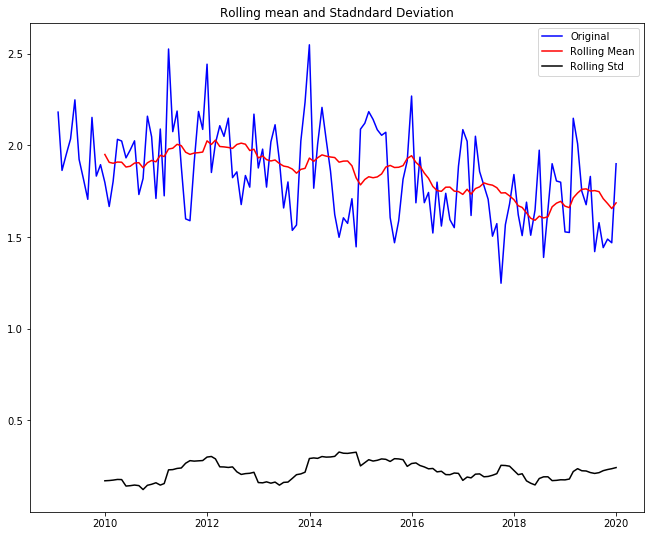

Results of Dickey-Fuller Test:
Test Statistic            -7.289676e+00
P-value                    1.428093e-10
Lags Used                  0.000000e+00
Num of observation Used    1.310000e+02
Critical value (1%)       -3.481282e+00
Critical value (5%)       -2.883868e+00
Critical value (10%)      -2.578677e+00
dtype: float64


In [89]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # Determinig rolling Statistics
    moving_Average = timeseries.rolling(window=12).mean()
    moving_std = timeseries.rolling(window=12).std()
    # plot rolling statistics:
    original = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(moving_Average, color = 'red', label='Rolling Mean')
    std = plt.plot(moving_std, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title("Rolling mean and Stadndard Deviation")
    plt.show(block = False)
    # Dickey-Fuller test
    print("Results of Dickey-Fuller Test:")
    d_test = adfuller(timeseries['Horizontal wind speed at 16.8 m height'], autolag = 'AIC')
    df_output = pd.Series(d_test[0:4], index = ['Test Statistic', 'P-value',
                                           'Lags Used', 'Num of observation Used'])
    for key, value in d_test[4].items():
        df_output['Critical value (%s)'%key] = value
    print(df_output)
    
    
    
data1=data.resample('M').mean()
test_stationarity(data1)

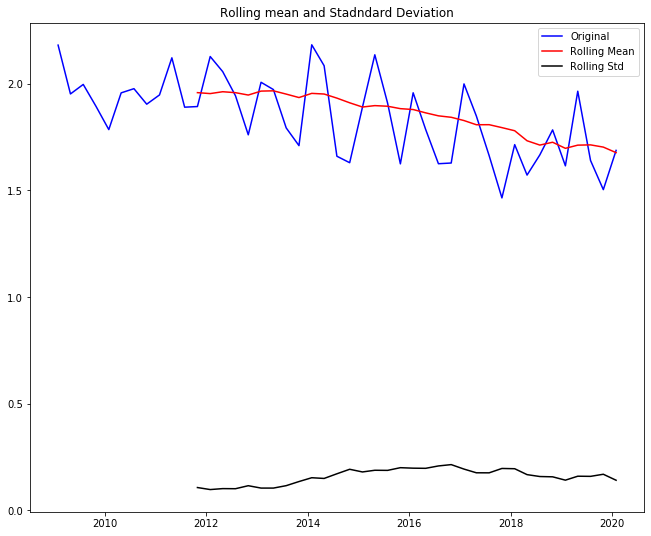

Results of Dickey-Fuller Test:
Test Statistic              0.063628
P-value                     0.963488
Lags Used                   7.000000
Num of observation Used    37.000000
Critical value (1%)        -3.620918
Critical value (5%)        -2.943539
Critical value (10%)       -2.610400
dtype: float64


In [90]:
data2=data.resample('3M').mean()
test_stationarity(data2)

In [91]:
data=data.resample('M').mean()

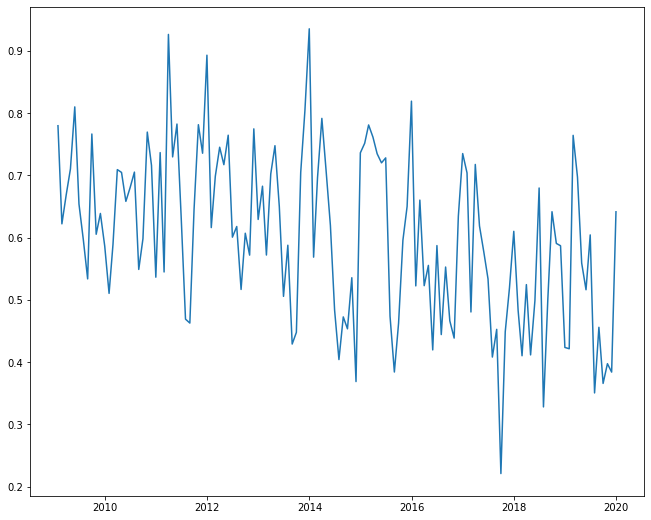

In [92]:
import numpy as np
# Estimating log trend
data_log_Scale = np.log(data)
plt.plot(data_log_Scale)
plt.show(block = False)

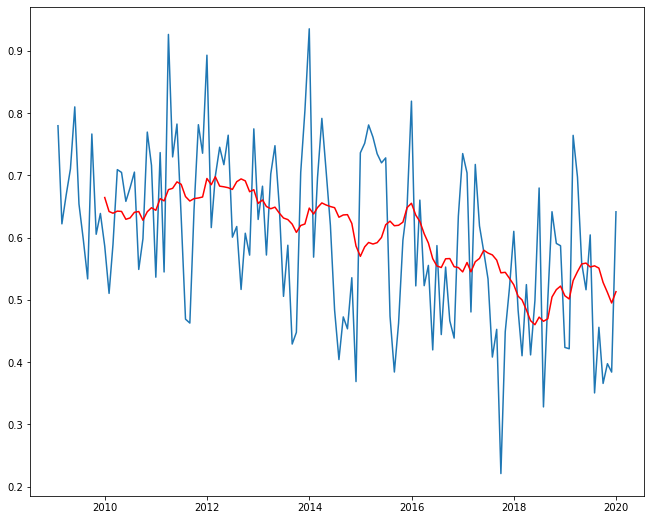

In [93]:
# Moving Average and STD with Log Scale
moving_Average = data_log_Scale.rolling(window=12).mean()
moving_Std = data_log_Scale.rolling(window=12).std()

plt.plot(data_log_Scale)
plt.plot(moving_Average, color = 'red')
plt.show()

In [94]:
data_Log_Scale_Minus_Mov_Av = data_log_Scale - moving_Average
data_Log_Scale_Minus_Mov_Av.head(12)

# Removing NaN Values
data_Log_Scale_Minus_Mov_Av.dropna(inplace = True)
data_Log_Scale_Minus_Mov_Av.head(10)

,Horizontal wind speed at 16.8 m height
Time,
2009-12-31,-0.078043
2010-01-31,-0.131496
2010-02-28,-0.050016
2010-03-31,0.066690
2010-04-30,0.062630
2010-05-31,0.028808
2010-06-30,0.048438
2010-07-31,0.064569
2010-08-31,-0.092997


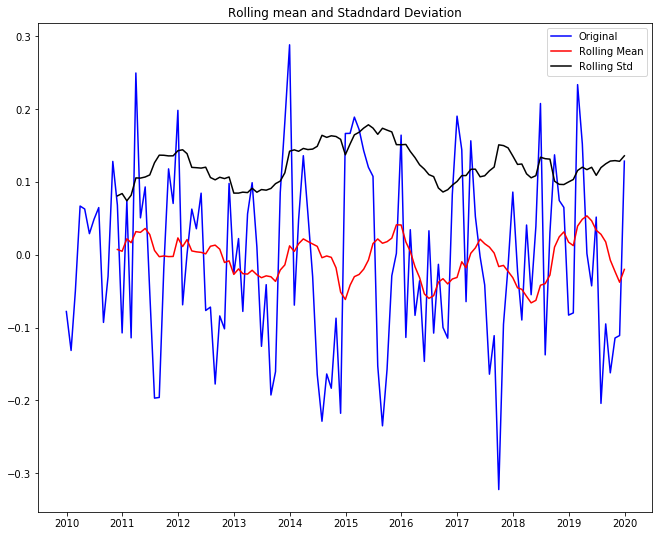

Results of Dickey-Fuller Test:
Test Statistic            -6.051325e+00
P-value                    1.275517e-07
Lags Used                  7.000000e+00
Num of observation Used    1.130000e+02
Critical value (1%)       -3.489590e+00
Critical value (5%)       -2.887477e+00
Critical value (10%)      -2.580604e+00
dtype: float64


In [95]:
test_stationarity(data_Log_Scale_Minus_Mov_Av)
#test_stationarity(data_log_Scale)

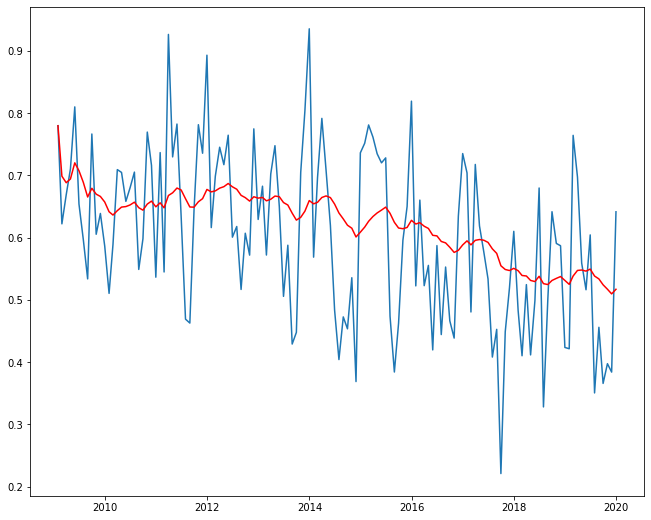

In [96]:
exponential_Decay_Weighted_Avg = data_log_Scale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(data_log_Scale)
plt.plot(exponential_Decay_Weighted_Avg,color='red')
plt.show()

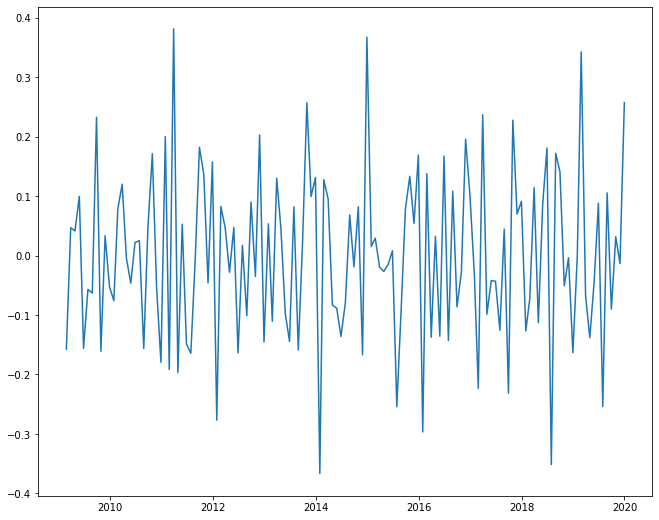

In [97]:
data_log_Diff_Shifting = data_log_Scale - data_log_Scale.shift()
plt.plot(data_log_Diff_Shifting)

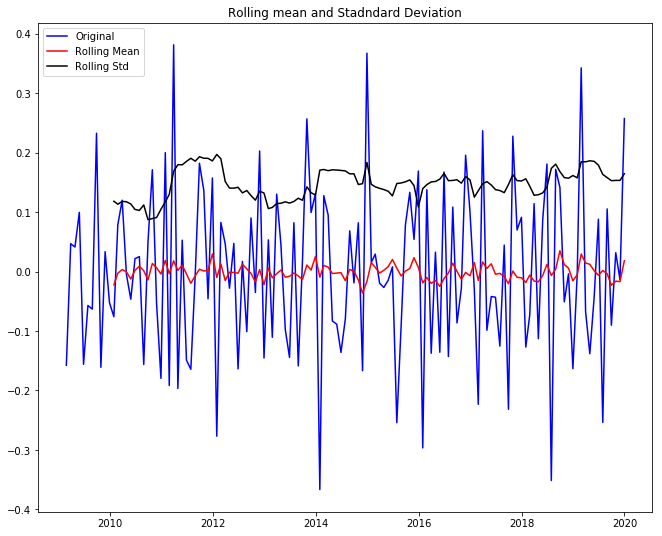

Results of Dickey-Fuller Test:
Test Statistic            -7.304114e+00
P-value                    1.315157e-10
Lags Used                  1.000000e+01
Num of observation Used    1.200000e+02
Critical value (1%)       -3.486056e+00
Critical value (5%)       -2.885943e+00
Critical value (10%)      -2.579785e+00
dtype: float64


In [248]:
data_log_Diff_Shifting.dropna(inplace=True)
test_stationarity(data_log_Diff_Shifting)

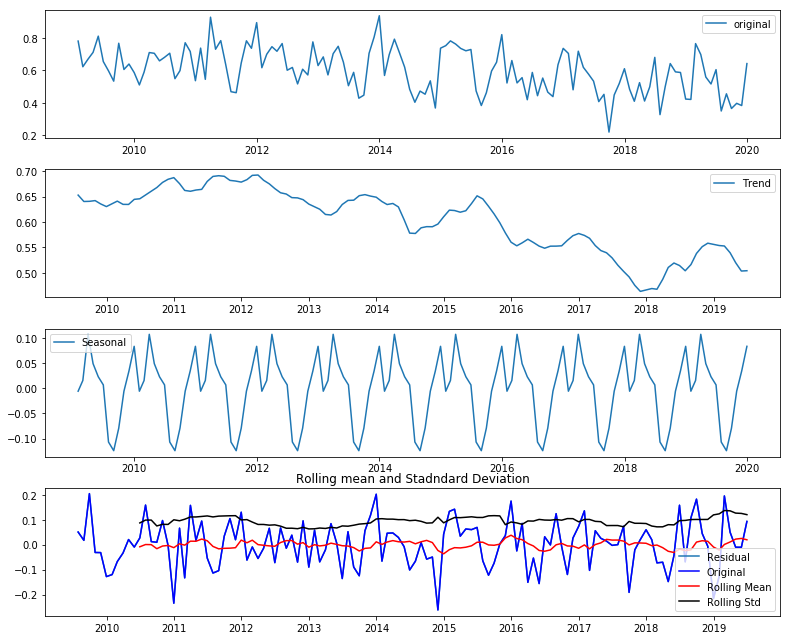

Results of Dickey-Fuller Test:
Test Statistic            -6.807478e+00
P-value                    2.158250e-09
Lags Used                  5.000000e+00
Num of observation Used    1.140000e+02
Critical value (1%)       -3.489058e+00
Critical value (5%)       -2.887246e+00
Critical value (10%)      -2.580481e+00
dtype: float64


In [249]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data_log_Scale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log_Scale, label = 'original')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = "Trend")
plt.legend(loc = "best")

plt.subplot(413)
plt.plot(seasonal, label = "Seasonal")
plt.legend(loc = "best")

plt.subplot(414)
plt.plot(residual, label = "Residual")
plt.legend(loc = "best")
plt.tight_layout()

decomposed_Log_data = residual
decomposed_Log_data.dropna(inplace=True)
test_stationarity(decomposed_Log_data)
plt.show()

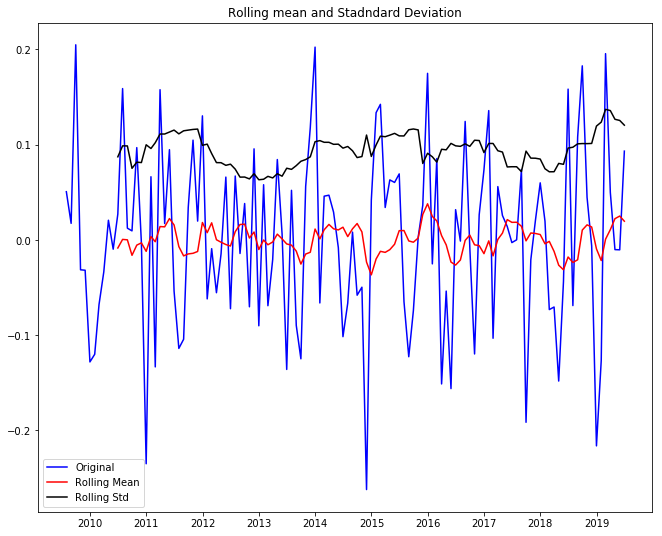

Results of Dickey-Fuller Test:
Test Statistic            -6.807478e+00
P-value                    2.158250e-09
Lags Used                  5.000000e+00
Num of observation Used    1.140000e+02
Critical value (1%)       -3.489058e+00
Critical value (5%)       -2.887246e+00
Critical value (10%)      -2.580481e+00
dtype: float64


In [250]:
decomposed_Log_data = residual
decomposed_Log_data.dropna(inplace=True)
test_stationarity(decomposed_Log_data)

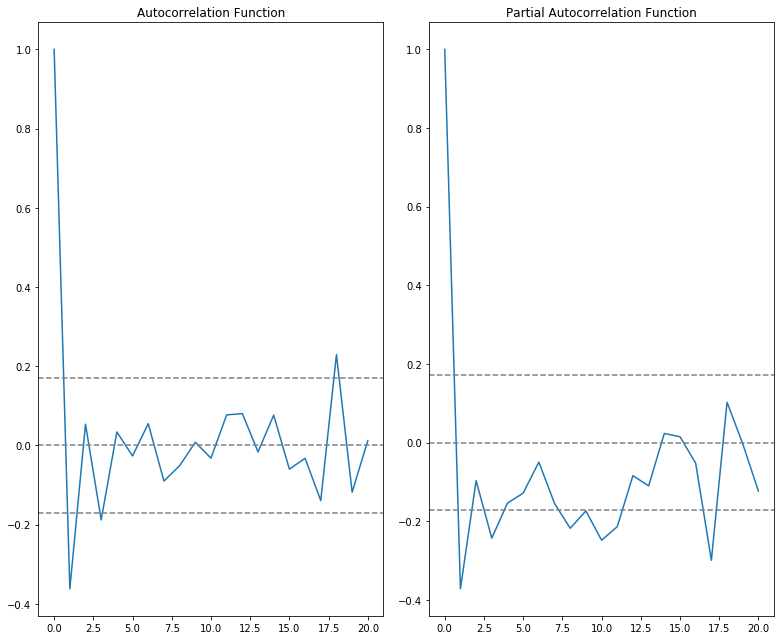

In [251]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(data_log_Diff_Shifting, nlags =20)
lag_pacf = pacf(data_log_Diff_Shifting, nlags=20, method='ols')

# Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_Diff_Shifting)), linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_Diff_Shifting)), linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_Diff_Shifting)), linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_Diff_Shifting)), linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In [32]:
data1.head()

,Horizontal wind speed at 16.8 m height
Time,
2009-01-31,2.180534
2009-02-28,1.862597
2009-03-31,1.952014
2009-04-30,2.034394
2009-05-31,2.247505


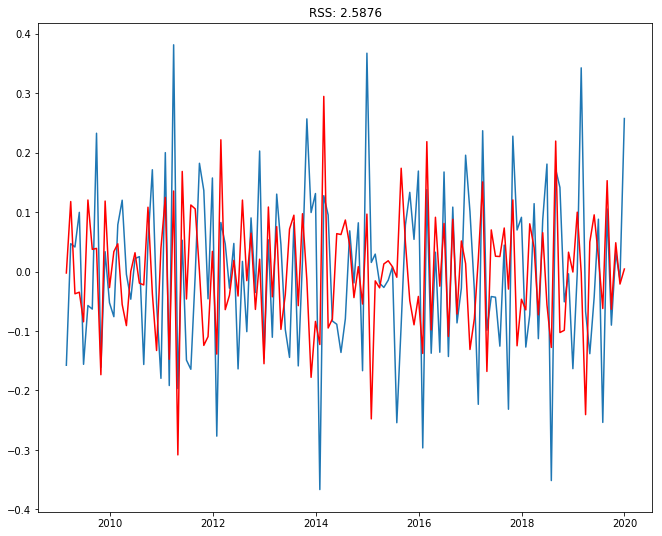

Plotting AR model


In [252]:
from statsmodels.tsa.arima_model import ARIMA

#AR Model
model = ARIMA(data1, order=(1, 1, 0))
results_AR = model.fit(disp=-1)
plt.plot(data_log_Diff_Shifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-data_log_Diff_Shifting['Horizontal wind speed at 16.8 m height'])**2))
plt.show()
print('Plotting AR model')

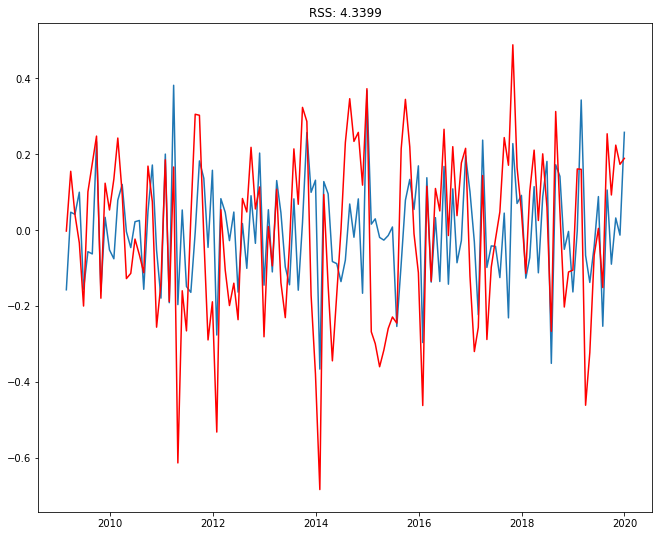

Plotting MA model


In [260]:
from statsmodels.tsa.arima_model import ARIMA

#MA Model
model = ARIMA(data1, order=(0, 1, 1))
results_MA = model.fit(disp=-1)
plt.plot(data_log_Diff_Shifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-data_log_Diff_Shifting['Horizontal wind speed at 16.8 m height'])**2))
plt.show()
print('Plotting MA model')

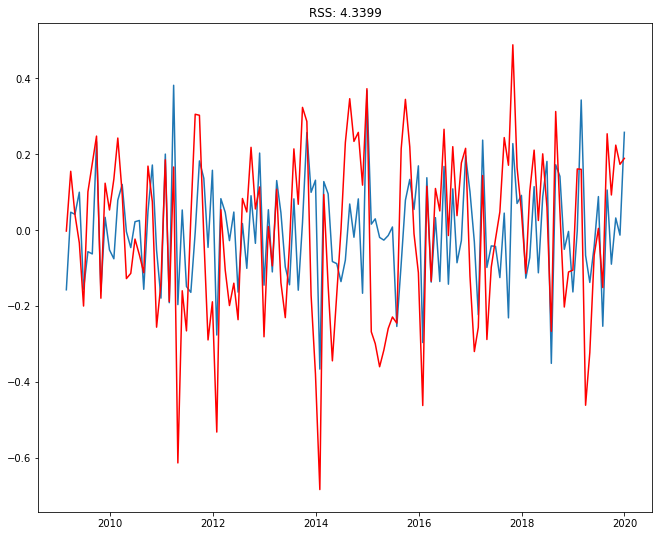

Plotting ARIMA model


In [254]:
from statsmodels.tsa.arima_model import ARIMA

#ARIMA Model
model = ARIMA(data1, order=(1, 1, 1))
results_ARIMA = model.fit(disp=-1)
plt.plot(data_log_Diff_Shifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-data_log_Diff_Shifting['Horizontal wind speed at 16.8 m height'])**2))
plt.show()
print('Plotting ARIMA model')

In [255]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy= True)
print(predictions_ARIMA_diff.head())

Time
2009-02-28   -0.002782
2009-03-31    0.106494
2009-04-30    0.038159
2009-05-31   -0.011845
2009-06-30   -0.123331
Freq: M, dtype: float64


In [256]:
 #Convert to Cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Time
2009-02-28   -0.002782
2009-03-31    0.103712
2009-04-30    0.141871
2009-05-31    0.130026
2009-06-30    0.006694
Freq: M, dtype: float64


In [257]:
predictions_ARIMA_log = pd.Series(data_log_Scale['Horizontal wind speed at 16.8 m height'].iloc[0],index=data_log_Scale.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Time
2009-01-31    0.779570
2009-02-28    0.776787
2009-03-31    0.883282
2009-04-30    0.921441
2009-05-31    0.909596
Freq: M, dtype: float64

In [33]:
data.head()

,Horizontal wind speed at 16.8 m height
Time,
2009-01-31,2.180534
2009-02-28,1.862597
2009-03-31,1.952014
2009-04-30,2.034394
2009-05-31,2.247505


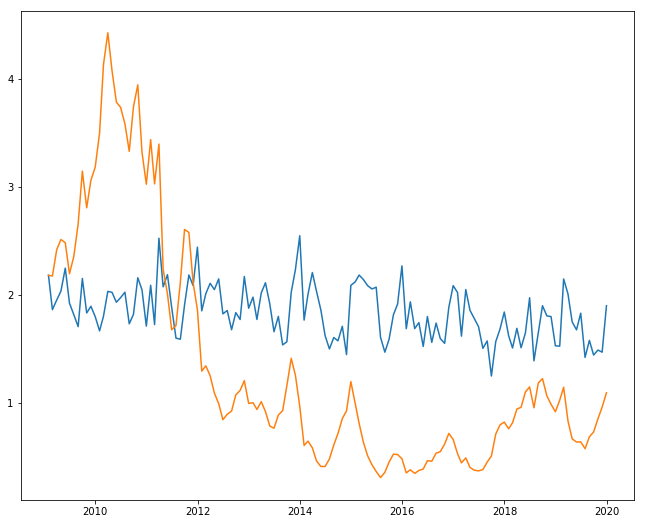

In [258]:
predictions_ARIMA= np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)

In [259]:
predictions_ARIMA.tail()

Time
2019-08-31    0.683171
2019-09-30    0.728230
2019-10-31    0.850057
2019-11-30    0.958177
2019-12-31    1.091833
Freq: M, dtype: float64

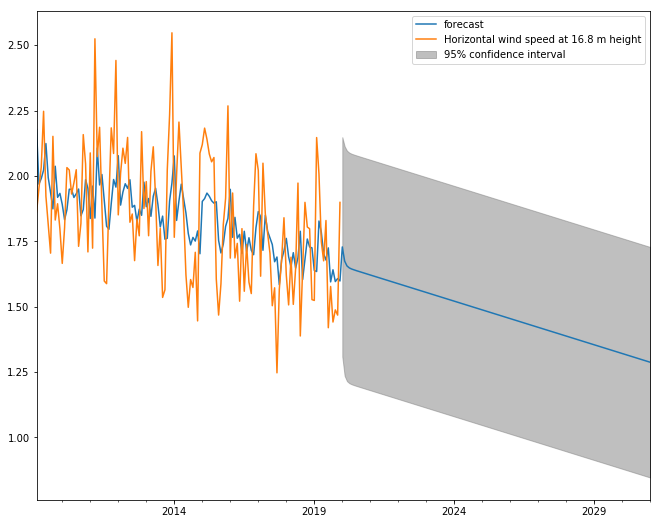

In [240]:
results_ARIMA.plot_predict(1,264)
x=results_ARIMA.forecast(steps=120)